In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import math

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, condition_channels=1, base_channels=64):
        super().__init__()
        
        # Condition embedding
        self.condition_conv = nn.Sequential(
            nn.Conv2d(condition_channels, base_channels, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
        )
        
        # Time embedding
        time_emb_dim = base_channels * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        
        # Encoder
        self.enc1 = self._make_enc_block(in_channels + base_channels, base_channels, time_emb_dim)
        self.enc2 = self._make_enc_block(base_channels, base_channels*2, time_emb_dim)
        self.enc3 = self._make_enc_block(base_channels*2, base_channels*4, time_emb_dim)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
        )
        
        # Decoder
        self.dec3 = self._make_dec_block(base_channels*8, base_channels*2, time_emb_dim)
        self.dec2 = self._make_dec_block(base_channels*4, base_channels, time_emb_dim)
        self.dec1 = self._make_dec_block(base_channels*2, base_channels, time_emb_dim)
        
        # Output
        self.final = nn.Conv2d(base_channels, in_channels, 3, padding=1)
        
    def _make_enc_block(self, in_channels, out_channels, time_emb_dim):
        return TimestepEmbedSequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.SiLU(),
            Residual(TimeEmbedding(time_emb_dim, out_channels)),
            nn.MaxPool2d(2)
        )
    
    def _make_dec_block(self, in_channels, out_channels, time_emb_dim):
        return TimestepEmbedSequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.SiLU(),
            Residual(TimeEmbedding(time_emb_dim, out_channels)),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
    
    def forward(self, x, condition, t):
        # Embed condition
        condition_emb = self.condition_conv(condition)
        
        # Embed time
        t_emb = self.time_mlp(t)
        
        # Concatenate input and condition
        x = torch.cat([x, condition_emb], dim=1)
        
        # Encoder
        e1 = self.enc1(x, t_emb)
        e2 = self.enc2(e1, t_emb)
        e3 = self.enc3(e2, t_emb)
        
        # Bottleneck
        bottle = self.bottleneck(e3)
        
        # Decoder with skip connections
        d3 = self.dec3(torch.cat([bottle, e3], dim=1), t_emb)
        d2 = self.dec2(torch.cat([d3, e2], dim=1), t_emb)
        d1 = self.dec1(torch.cat([d2, e1], dim=1), t_emb)
        
        return self.final(d1)

# Helper classes for proper time embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class TimeEmbedding(nn.Module):
    def __init__(self, time_emb_dim, out_channels):
        super().__init__()
        self.linear = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x, t_emb):
        t_emb = self.linear(t_emb)
        return x + t_emb[..., None, None]

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

class TimestepEmbedSequential(nn.Sequential):
    def forward(self, x, t_emb):
        for layer in self:
            if isinstance(layer, (TimeEmbedding, Residual)):
                x = layer(x, t_emb)
            else:
                x = layer(x)
        return x

# Modified training loop
def train_epoch(model, diffusion, dataloader, optimizer, device, conditional=True):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        if conditional:
            x, condition = batch
            x, condition = x.to(device), condition.to(device)
        else:
            x = batch[0].to(device)
            condition = x  # Use input as condition for enhancement
            
        optimizer.zero_grad()
        
        # Sample random timesteps
        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
        
        # Get noisy image and noise
        x_t, noise = diffusion.forward_diffusion(x, condition, t)
        
        # Predict noise
        predicted_noise = model(x_t, condition, t)
        
        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

class ConditionalDiffusion:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Setup noise schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
    
    def forward_diffusion(self, x_0, condition, t):
        """Forward diffusion with condition"""
        noise = torch.randn_like(x_0, device=self.device)
        t = t.to(self.device)
        
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def sample(self, model, condition, shape, device):
        """Conditional sampling"""
        x_t = torch.randn(shape, device=device)
        
        for t in range(self.num_timesteps - 1, -1, -1):
            t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
            
            # No noise for last step
            if t == 0:
                noise = 0
            else:
                noise = torch.randn_like(x_t)
            
            # Get model prediction using condition
            predicted_noise = model(x_t, condition, t_batch)
            
            alpha_t = self.alphas[t]
            alpha_t_cumprod = self.alphas_cumprod[t]
            beta_t = self.betas[t]
            
            x_t = (1 / torch.sqrt(alpha_t)) * (
                x_t - (beta_t / torch.sqrt(1 - alpha_t_cumprod)) * predicted_noise
            ) + torch.sqrt(beta_t) * noise
        
        return x_t

class ImageEnhancementDataset(Dataset):
    """Dataset for image enhancement training"""
    def __init__(self, high_quality_images, degradation_transform):
        self.images = high_quality_images
        self.degradation = degradation_transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        high_quality = self.images[idx]
        low_quality = self.degradation(high_quality)
        return low_quality, high_quality

def create_degradation_transform(degradation_type='noise'):
    """Create transform to degrade image quality"""
    if degradation_type == 'noise':
        return lambda x: x + torch.randn_like(x) * 0.1
    elif degradation_type == 'blur':
        return lambda x: F.gaussian_blur(x, kernel_size=[5,5], sigma=2.0)
    elif degradation_type == 'compression':
        return transforms.Compose([
            transforms.ToPILImage(),
            lambda x: x.save('temp.jpg', quality=30),
            transforms.ToTensor()
        ])
    else:
        raise ValueError(f"Unknown degradation type: {degradation_type}")

# Training utilities
def train_conditional_diffusion(model, diffusion, dataloader, optimizer, num_epochs, device):
    """Training loop for conditional diffusion"""
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch, condition in dataloader:
            batch, condition = batch.to(device), condition.to(device)
            optimizer.zero_grad()
            
            # Sample random timesteps
            t = torch.randint(0, diffusion.num_timesteps, (batch.shape[0],), device=device)
            
            # Get noisy image and noise
            x_t, noise = diffusion.forward_diffusion(batch, condition, t)
            
            # Predict noise
            predicted_noise = model(x_t, condition, t)
            
            # Calculate loss
            loss = F.mse_loss(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(dataloader):.4f}")

# Example usage
def enhance_image(image, model, diffusion, device):
    """Enhance image quality using diffusion model"""
    model.eval()
    with torch.no_grad():
        # Use low quality image as condition
        enhanced = diffusion.sample(model, image.unsqueeze(0), image.shape, device)
    return enhanced.squeeze(0)

Generating datasets...
Using device: cuda

Training Conditional Generation Model...


Training: 100%|██████████| 250/250 [00:02<00:00, 86.41it/s]


Epoch 10, Loss: 0.4964


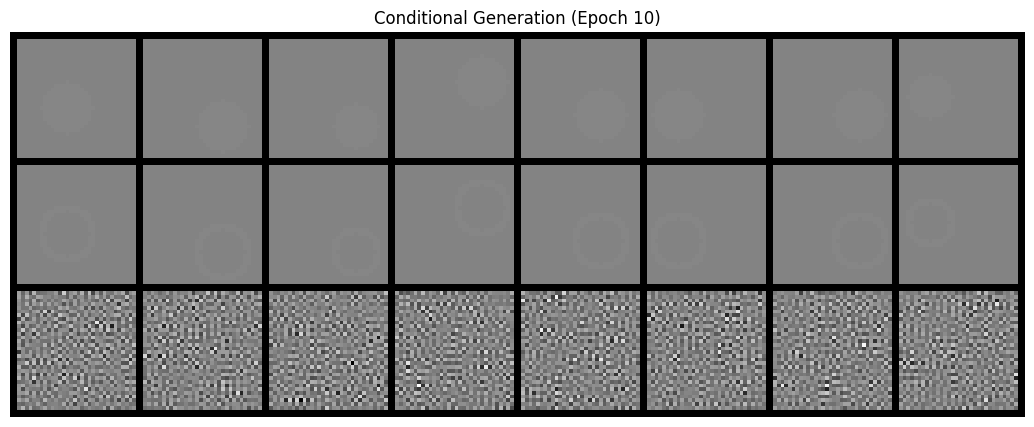

Training: 100%|██████████| 250/250 [00:02<00:00, 85.32it/s]


Epoch 20, Loss: 0.4203


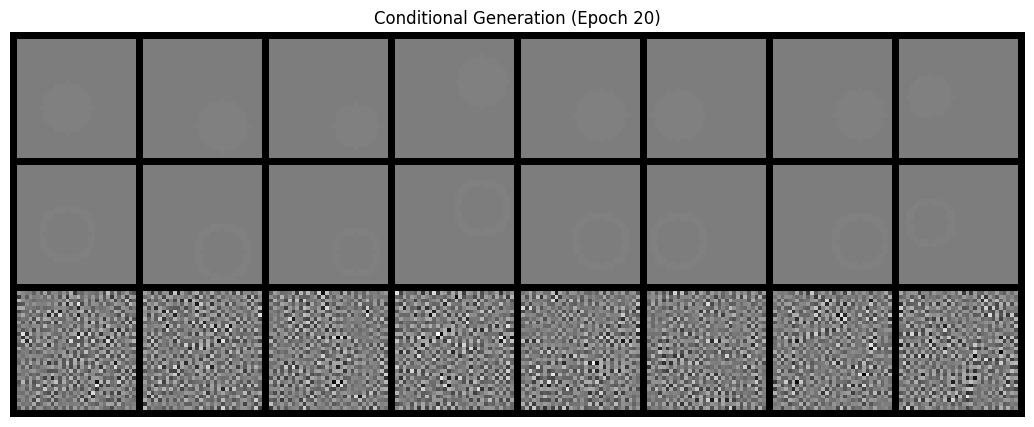

Training: 100%|██████████| 250/250 [00:02<00:00, 86.89it/s]


Epoch 30, Loss: 0.3784


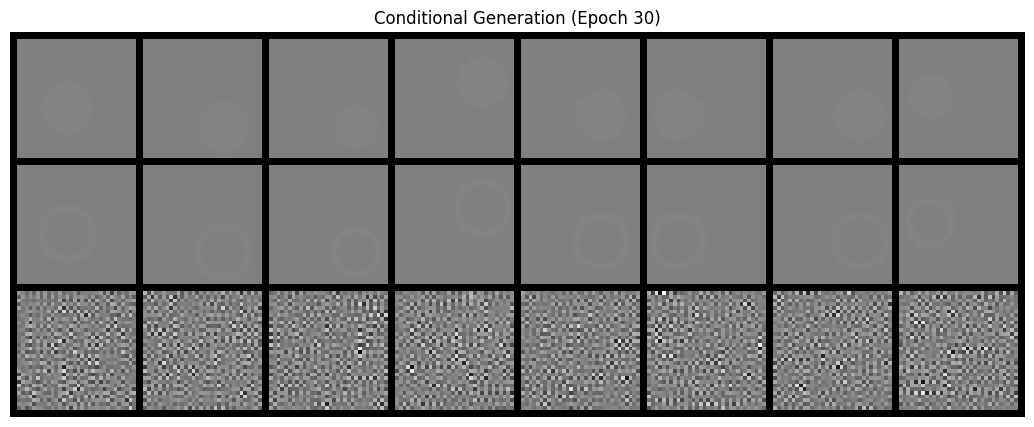

Training: 100%|██████████| 250/250 [00:02<00:00, 99.99it/s] 


Epoch 40, Loss: 0.3536


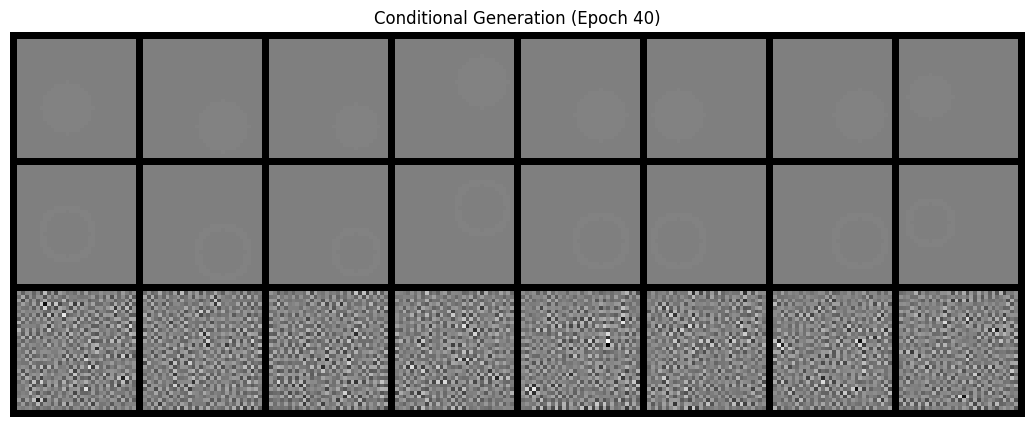

Training: 100%|██████████| 250/250 [00:02<00:00, 83.61it/s]


Epoch 50, Loss: 0.3340


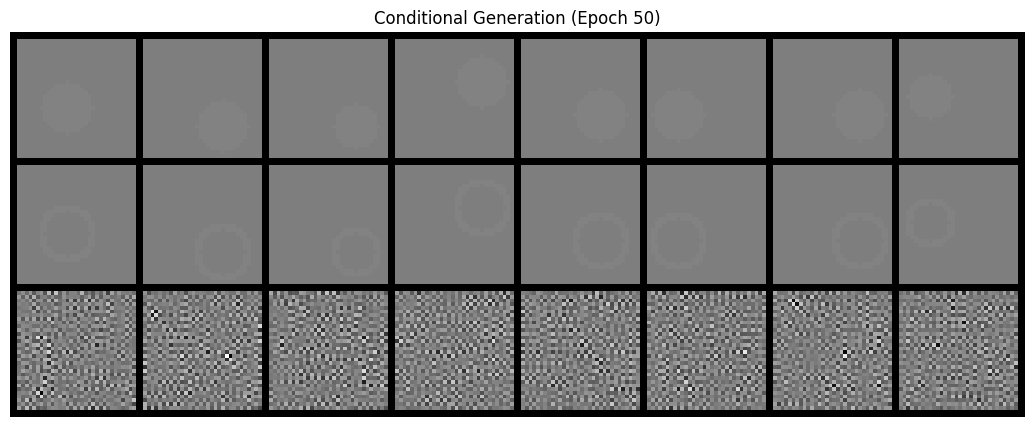


Training Enhancement Model...


Training: 100%|██████████| 250/250 [00:03<00:00, 82.34it/s]


Epoch 10, Loss: 0.5001


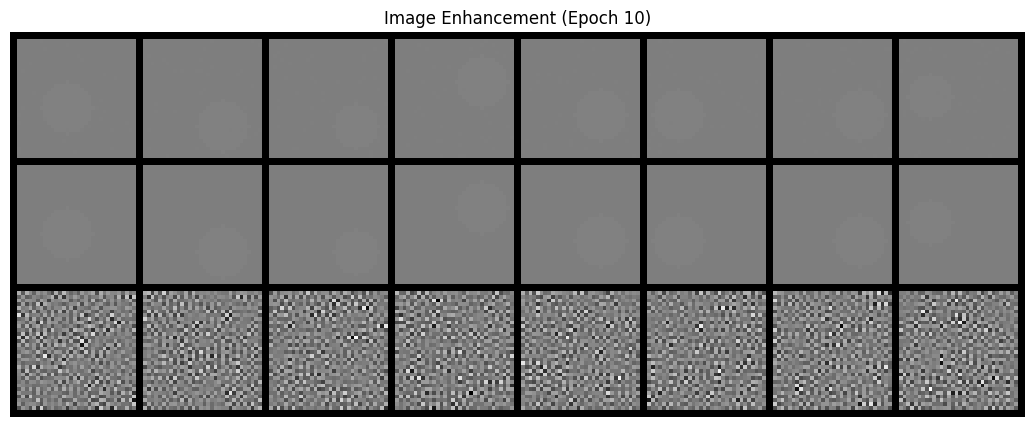

Training: 100%|██████████| 250/250 [00:03<00:00, 80.89it/s]


Epoch 20, Loss: 0.4083


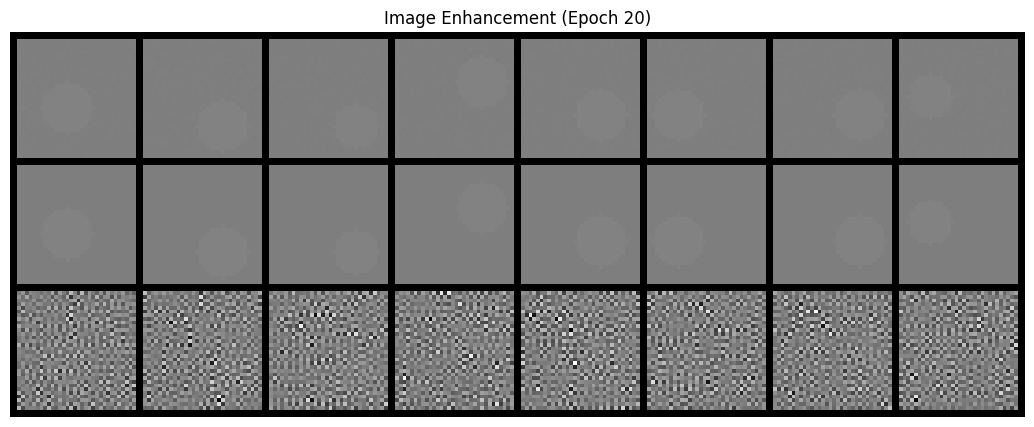

Training: 100%|██████████| 250/250 [00:02<00:00, 107.20it/s]


Epoch 30, Loss: 0.3698


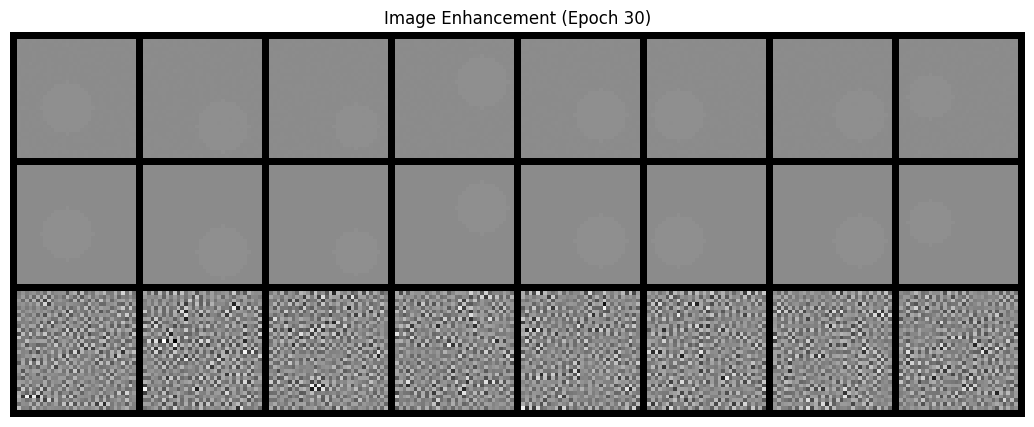

Training: 100%|██████████| 250/250 [00:02<00:00, 100.71it/s]


Epoch 40, Loss: 0.3445


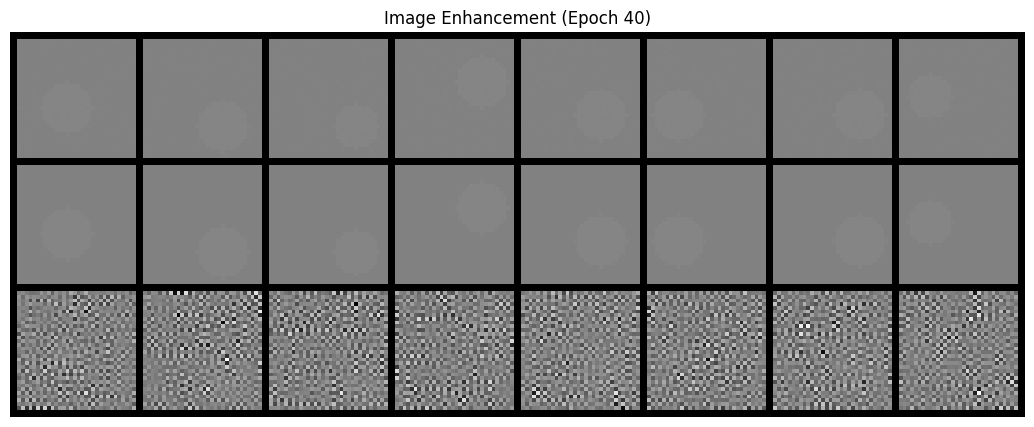

Training: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Epoch 50, Loss: 0.3273


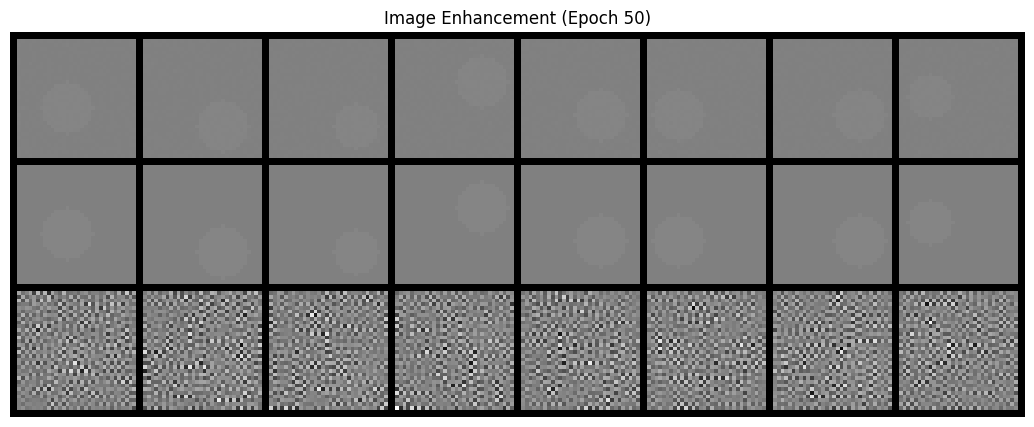


Final Results:


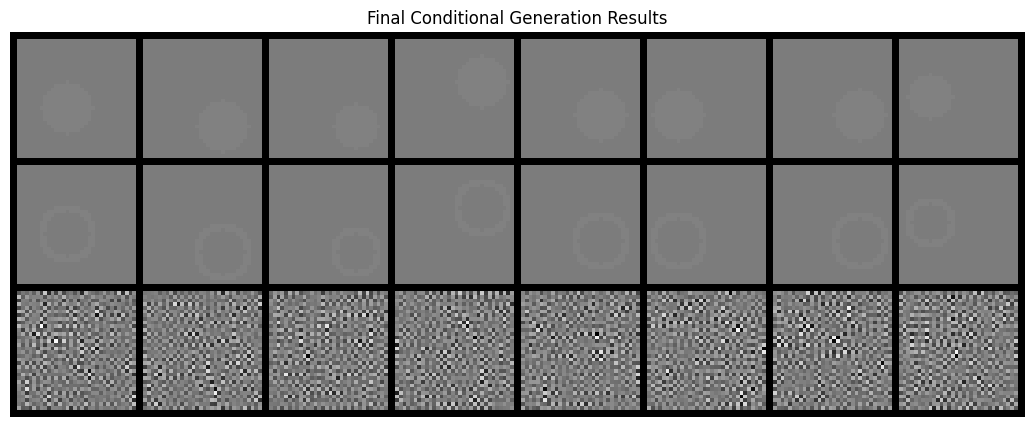

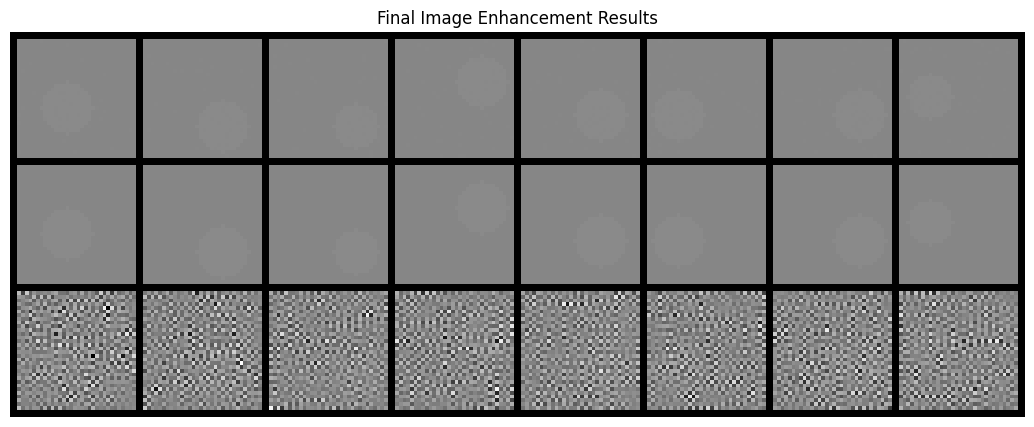

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm

def create_shapes_dataset(num_samples=10000, image_size=32):
    """
    Generate dataset of shapes (circles and squares) with different sizes
    Returns both shapes and their edge maps as conditions
    """
    images = []
    conditions = []  # Edge maps will serve as conditions
    
    for _ in range(num_samples):
        # Create empty image and condition
        image = np.zeros((image_size, image_size))
        condition = np.zeros((image_size, image_size))
        
        # Random position
        center_x = np.random.randint(image_size // 4, 3 * image_size // 4)
        center_y = np.random.randint(image_size // 4, 3 * image_size // 4)
        
        # Random size
        size = np.random.randint(image_size // 8, image_size // 4)
        
        # Randomly choose between circle and square
        if np.random.random() < 0.9:
            # Draw circle
            y, x = np.ogrid[:image_size, :image_size]
            dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            image[dist_from_center <= size] = 1.0
            # Create edge condition
            condition[np.abs(dist_from_center - size) < 1] = 1.0
        else:
            # Draw square
            x_start = max(0, center_x - size)
            x_end = min(image_size, center_x + size)
            y_start = max(0, center_y - size)
            y_end = min(image_size, center_y + size)
            
            image[y_start:y_end, x_start:x_end] = 1.0
            # Create edge condition
            condition[y_start:y_end, x_start] = 1.0
            condition[y_start:y_end, x_end-1] = 1.0
            condition[y_start, x_start:x_end] = 1.0
            condition[y_end-1, x_start:x_end] = 1.0
        
        images.append(image)
        conditions.append(condition)
    
    # Convert to torch tensors
    images = torch.FloatTensor(images).unsqueeze(1)  # Add channel dimension
    conditions = torch.FloatTensor(conditions).unsqueeze(1)
    
    return images, conditions

def create_noisy_dataset(clean_images, noise_level=0.1):
    """
    Create noisy versions of images for enhancement training
    """
    noisy_images = clean_images + torch.randn_like(clean_images) * noise_level
    noisy_images = torch.clamp(noisy_images, 0, 1)
    return noisy_images

# Create datasets
print("Generating datasets...")
images, conditions = create_shapes_dataset(num_samples=10000)
noisy_images = create_noisy_dataset(images)

# Split into train and test
train_size = int(0.8 * len(images))
train_images, test_images = images[:train_size], images[train_size:]
train_conditions, test_conditions = conditions[:train_size], conditions[train_size:]
train_noisy, test_noisy = noisy_images[:train_size], noisy_images[train_size:]

# Create dataloaders
batch_size = 32
train_loader_conditional = DataLoader(list(zip(train_images, train_conditions)), 
                                    batch_size=batch_size, shuffle=True)
test_loader_conditional = DataLoader(list(zip(test_images, test_conditions)), 
                                   batch_size=batch_size)

train_loader_enhancement = DataLoader(list(zip(train_noisy, train_images)), 
                                    batch_size=batch_size, shuffle=True)
test_loader_enhancement = DataLoader(list(zip(test_noisy, test_images)), 
                                   batch_size=batch_size)

def train_epoch(model, diffusion, dataloader, optimizer, device, conditional=True):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        if conditional:
            x, condition = batch
            x, condition = x.to(device), condition.to(device)
        else:
            x = batch[0].to(device)
            condition = x  # Use input as condition for enhancement
            
        optimizer.zero_grad()
        
        # Sample random timesteps
        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
        
        # Get noisy image and noise
        x_t, noise = diffusion.forward_diffusion(x, condition, t)
        
        # Predict noise
        predicted_noise = model(x_t, condition, t)
        
        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def visualize_results(model, diffusion, dataloader, device, title, num_samples=8):
    """Visualize original, condition/noisy, and generated images"""
    model.eval()
    with torch.no_grad():
        # Get a batch
        batch = next(iter(dataloader))
        original = batch[0][:num_samples].to(device)
        condition = batch[1][:num_samples].to(device)
        
        # Generate samples
        samples = diffusion.sample(model, condition, original.shape, device)
        
        # Create visualization grid
        viz = torch.cat([original.cpu(), condition.cpu(), samples.cpu()], dim=0)
        grid = make_grid(viz, nrow=num_samples, normalize=True, padding=2)
        
        plt.figure(figsize=(15, 5))
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
conditional_model = ConditionalUNet(in_channels=1, condition_channels=1).to(device)
enhancement_model = ConditionalUNet(in_channels=1, condition_channels=1).to(device)

diffusion = ConditionalDiffusion(num_timesteps=500, device=device)

# Optimizers
conditional_optimizer = torch.optim.Adam(conditional_model.parameters(), lr=1e-4)
enhancement_optimizer = torch.optim.Adam(enhancement_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 50
print("\nTraining Conditional Generation Model...")
for epoch in range(num_epochs):
    loss = train_epoch(conditional_model, diffusion, train_loader_conditional, 
                      conditional_optimizer, device, conditional=True)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
        visualize_results(conditional_model, diffusion, test_loader_conditional, 
                        device, f"Conditional Generation (Epoch {epoch+1})")

print("\nTraining Enhancement Model...")
for epoch in range(num_epochs):
    loss = train_epoch(enhancement_model, diffusion, train_loader_enhancement, 
                      enhancement_optimizer, device, conditional=False)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
        visualize_results(enhancement_model, diffusion, test_loader_enhancement, 
                        device, f"Image Enhancement (Epoch {epoch+1})")

# Final visualization
print("\nFinal Results:")
visualize_results(conditional_model, diffusion, test_loader_conditional, 
                 device, "Final Conditional Generation Results")
visualize_results(enhancement_model, diffusion, test_loader_enhancement, 
                 device, "Final Image Enhancement Results")